In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.noise import *

In [2]:
log2 = 12

In [3]:
# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

[]

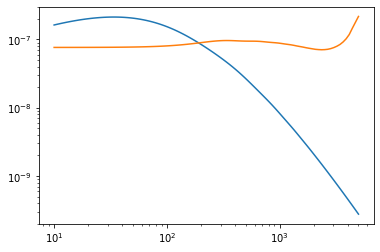

In [4]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

    
plt.plot(ells, ClKK)
plt.plot(ells, f_N0(ells))
plt.loglog()

In [5]:
# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)

Ik_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_zmin_%.5f_zmax_%.5f_chi_sample_%d.npy'%(zmin, zmax, log2)
I_kappa = np.load(Ik_fname)

In [6]:
external_chis   = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), 2**log2)

In [7]:
from scipy.integrate import simpson, trapezoid

In [8]:
SNR2_per_mode_diag = {}
SNR2_per_mode_full = {}
SNR2_per_mode_sanity = {}

integrand =  I_kappa**2 / (1/external_chis**2)
SNR2_per_mode_diag[0.0] = trapezoid(x = external_chis, y = integrand)/(ClKK + f_N0(ells)) 
SNR2_per_mode_full[0.0] = SNR2_per_mode_diag[0.0]
SNR2_per_mode_sanity[0.0] = SNR2_per_mode_diag[0.0]

Lambda_idx = -1
for Lambda in tqdm(Lambdas):
    Lambda_idx += 1
    ILo_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_%d.npy'%(zmin, zmax, Lambda, log2)
    ILo_kappa = np.load(ILo_kappa_fname)
    IHi_kappa = I_kappa - ILo_kappa


    integrand =  IHi_kappa**2 / (1/external_chis**2) # [kJy^2/sr^2][Mpc^4]
    # total integral has unit #[kJy^2 / sr^2][Mpc^3] 
    SNR2_per_mode_diag[Lambda] = simpson(x = external_chis,
                                         y = integrand)/(ClKK + f_N0(ells)) 

    try:
#         D = np.diag(external_chis)
#         d = D @ IHi_kappa.T

        computed_oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/snr_per_mode_scipy_zmin_%.5f_zmax_%.5f_Lambda_idx_%d_log2_%d'%(zmin, zmax, Lambda_idx, log2)
        oup1_fname = computed_oup_fname + '_full.npy'
        oup2_fname = computed_oup_fname + '_diag.npy'
        SNR2_per_mode_full[Lambda]   = np.load(oup1_fname)
        SNR2_per_mode_sanity[Lambda] = np.load(oup2_fname)
    except:
        print('skipping', Lambda_idx, Lambda)
#moved to 005.011.*.py
#     noise_fname_base = '/scratch/users/delon/LIMxCMBL/eHIeHI/scipy_zmin_%.5f_zmax_%.5f_Lambda_%.5e_%d'%(zmin, zmax, Lambda, log2)

#     eIeI = np.load(noise_fname_base + '_eIeI.npy')
#     ecross = np.load(noise_fname_base + '_cross.npy')
#     eLOeLO = np.load(noise_fname_base + '_eLOeLO.npy')
#     eHIeHI = np.real(eIeI + eLOeLO - ecross)

#     L = np.linalg.cholesky(D @ eHIeHI @ D)
#     y = np.linalg.solve(L, d)
#     x = np.linalg.solve(L.T, y)
#     SNR2_per_mode_full[Lambda]   = np.einsum('ij, ji->i', d.T, x) / (ClKK + f_N0(ells))

#     L = np.linalg.cholesky(D @ eIeI @ D)
#     y = np.linalg.solve(L, d)
#     x = np.linalg.solve(L.T, y)
#     SNR2_per_mode_sanity[Lambda] = np.einsum('ij, ji->i', d.T, x) / (ClKK + f_N0(ells))
    

100%|██████████| 25/25 [00:00<00:00, 54.89it/s]

skipping 14 0.002154434690031882
skipping 16 0.004641588833612777
skipping 17 0.006812920690579608
skipping 18 0.01
skipping 19 0.01467799267622069
skipping 20 0.021544346900318822
skipping 21 0.03162277660168379
skipping 22 0.046415888336127774
skipping 23 0.06812920690579609
skipping 24 0.1


In [9]:
Lambdas = np.array(sorted(list(SNR2_per_mode_full.keys())))

In [10]:
rainbow_colors = plt.cm.rainbow(np.linspace(0, 1, len(SNR2_per_mode_diag)))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=rainbow_colors[::-1])

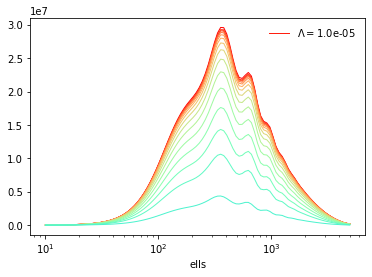

In [11]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_diag[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

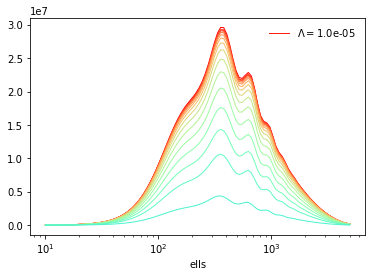

In [12]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_sanity[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

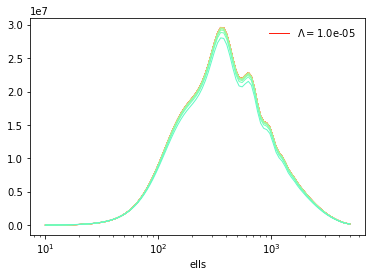

In [13]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas[:-1]:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_full[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

In [14]:
plt.show()
plt.rcParams['text.usetex'] = True

In [15]:
SNR2_per_Omega_per_invPei_full = np.zeros_like(Lambdas)
SNR2_per_Omega_per_invPei_sanity = np.zeros_like(Lambdas)

for Lambda_idx in range(len(Lambdas)):
    Lambda = Lambdas[Lambda_idx]    
    # [kJy^2 / sr^2][Mpc^3] \times 1/angle^2
    SNR2_per_Omega_per_invPei_full[Lambda_idx] = trapezoid(x = np.log(ells), 
                                           y = SNR2_per_mode_full[Lambda] * ells ** 2 / 2 / np.pi)
    
    SNR2_per_Omega_per_invPei_sanity[Lambda_idx] = trapezoid(x = np.log(ells), 
                                       y = SNR2_per_mode_sanity[Lambda] * ells ** 2 / 2 / np.pi)
    
SNR2_per_Omega_per_invPei_diag = np.zeros(len(SNR2_per_mode_diag))

for Lambda_idx,Lambda in enumerate(SNR2_per_mode_diag):
    SNR2_per_Omega_per_invPei_diag[Lambda_idx] = trapezoid(x = np.log(ells), 
                                                           y = SNR2_per_mode_diag[Lambda] * ells ** 2 / 2 / np.pi)


Text(0, 0.5, '$${\\sf SNR}^2 \\times \\frac 1 {{\\Omega}\\ [\\sf rad^2]}\\times {P^{\\epsilon_I}}\\left[\\sf Mpc^{3}\\frac{\\sf kJy^2}{\\sf sr^2} \\right]$$')

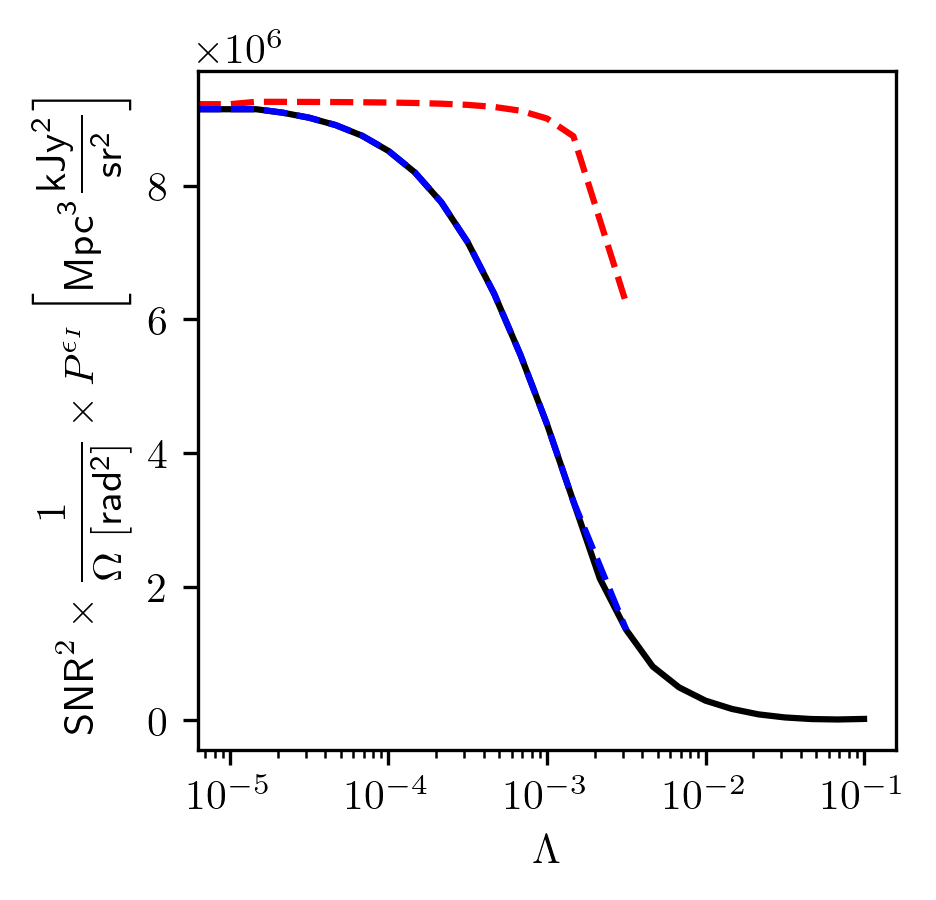

In [16]:
plt.figure(figsize = (3,3) ,dpi = 300, facecolor = 'w')

plt.plot(list(SNR2_per_mode_diag.keys()), (SNR2_per_Omega_per_invPei_diag), c='k')
plt.plot(Lambdas, (SNR2_per_Omega_per_invPei_full), 'r--')
plt.plot(Lambdas, (SNR2_per_Omega_per_invPei_sanity), 'b--')

plt.xscale('log')
fundamental = 2*np.pi/(chimax - chimin)

plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}^2 \times \frac 1 {{\Omega}\ [\sf rad^2]}\times {P^{\epsilon_I}}\left[\sf Mpc^{3}\frac{\sf kJy^2}{\sf sr^2} \right]$$')

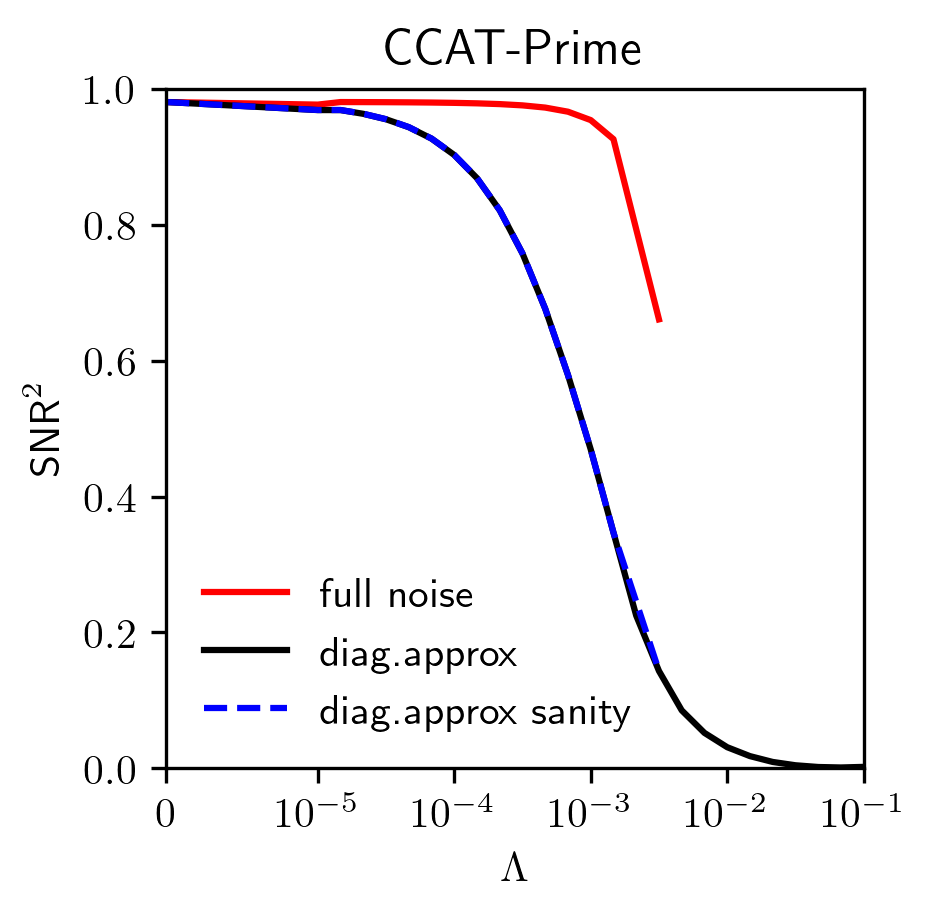

In [17]:
plt.figure(figsize = (3,3) ,dpi = 300, facecolor = 'w')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei_full * Omega_field / Pei), 
         'r-',
        label='full noise')

plt.plot(list(SNR2_per_mode_diag.keys()), 
         ((SNR2_per_Omega_per_invPei_diag) * Omega_field / Pei), 
         c='k',
        label='diag.approx')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei_sanity * Omega_field / Pei), 
         'b--',
        label='diag.approx sanity')


plt.xscale('symlog', linthresh = 1e-5)
fundamental = 2*np.pi/(chimax - chimin)
plt.xlim(0, 1e-1)
plt.ylim(0, 1)
plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}^2$$')
plt.title('CCAT-Prime')


plt.legend(frameon=False)